In [10]:
import warnings
warnings.filterwarnings("ignore")
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import fsspec
import json
from tqdm import tqdm
from glob import glob
from ncar_jobqueue import NCARCluster
import dask
import os
import xcesm
import intake
import seaborn as sns
from xCMIP import cmip_mdl
import pandas as pd
import proplot as pplt
import hvplot.pandas
import xcesm.plots.colormap as clp
pplt.rc.cycle = 'FlatUI'
pplt.rc.grid = 'off'

In [11]:
#pre1950
amv = xr.open_dataarray('0temp_data/gs.CMIP6.historical.AMV.JJASO.pub.pre1950.nc').convert_calendar('gregorian')
vws = xr.open_dataarray('0temp_data/gs.CMIP6.historical.VWS.JJASO.pub1.nc').convert_calendar('gregorian')
spr = xr.open_dataarray('0temp_data/gs.CMIP6.historical.Sahel-pr.JJASO.pub.pre1950.nc').convert_calendar('gregorian') * 86400
dsst = xr.open_dataarray('0temp_data/gs.CMIP6.historical.dSST.JJASO-annual.pub2.pre1950.nc').convert_calendar('gregorian')
ds = xr.merge([amv.rename('amv'),  vws.rename('vws'), spr.rename('spr'), dsst.rename('dsst')], join='inner')

In [12]:
#post1950
amv = xr.open_dataarray('0temp_data/gs.CMIP6.historical.AMV.JJASO.pub.nc').convert_calendar('gregorian')
vws = xr.open_dataarray('0temp_data/gs.CMIP6.historical.VWS.JJASO.pub1.nc').convert_calendar('gregorian')
spr = xr.open_dataarray('0temp_data/gs.CMIP6.historical.Sahel-pr.JJASO.pub.nc').convert_calendar('gregorian') * 86400
dsst = xr.open_dataarray('0temp_data/gs.CMIP6.historical.dSST.JJASO-annual.pub2.nc').convert_calendar('gregorian')
ds1 = xr.merge([amv.rename('amv'), vws.rename('vws'), spr.rename('spr'), dsst.rename('dsst')], join='inner')

In [13]:
dd = ds1.sel(time='1950') - ds.sel(time='1950') #cliamtology is removed in both periods

In [14]:
ds = xr.concat([ds+dd.squeeze().drop('time'), 
                ds1.sel(time=slice('1951','2014'))], dim='time') #concat the pre and post data

In [15]:
gbsst = xr.open_dataarray('0temp_data/gs.CMIP6.historical.gbSST.JJASO-annual.pub.1850-2015.nc').sel(time=slice('1950','2014')).convert_calendar('gregorian')
gbsst = gbsst.rename({'mmb':'mb'})
gbsst = gbsst.sel(mb=ds.mb)
gbsstmn = gbsst.mean('mb')

In [16]:
hist = ['hist-aer', 'hist-GHG', 'hist-nat']
gbSST = dict()

for hh in hist:
    tmp = xr.open_dataarray('0temp_data/gs.CMIP6.'+hh+'.gbSST.JJASO-annual.1850-2015.nc').sel(time=slice('1950','2014')).convert_calendar('gregorian')
    gbSST[hh] = tmp

In [17]:
df = pd.read_csv('0temp_data/regress_hemispheric_sst_on_DAMIP.csv', index_col='time')
df = df.to_xarray()
df['time'] = gbsst.time.sel(time=slice('1952','2012')) #remove the end point due to running mean

In [18]:
def is_amj(month):
    return (month >= 6) & (month <= 10)

def remove_monthly_climatology(ds):
    grp = ds.groupby('time.month')
    return grp - grp.mean('time')

def cal_amv(ts):
    return ts.sel(lat=slice(0, 60), lon=slice(290, 360)).utils.globalmean()

def rotate_lon(ds):
    ds = ds.assign_coords(lon2=(((ds.lon + 180) % 360) - 180)).sortby('lon2')
    ds = ds.swap_dims({'lon':'lon2'})
    return ds

def rotate_lon2(ds):
    ds['lon2'] = ds.lon2 % 360
    ds = ds.sortby('lon2')
    return ds


def area_ave(dss):
    # weight = np.cos(np.deg2rad(dss.lat))
    # return dss.weighted(weight).mean(['lat', 'lon2'])
    lat_cos = np.cos(np.deg2rad(dss.lat))
    return (dss * lat_cos).sum(['lat', 'lon2']) / (xr.ones_like(dss).where(~np.isnan(dss)) * lat_cos).sum(['lat', 'lon2'])


In [19]:
sst = xr.open_dataset('0temp_data/ERSST/sst.mnmean.nc').sortby('lat')
sst = sst.sst.sel(time=slice('1900', '2014'))
sst = sst.sel(time=is_amj(sst['time.month']))
sst = remove_monthly_climatology(sst)
sst = sst.resample(time='1Y').mean()
# sst = rotate_lon(sst)
amv_ersst = cal_amv(sst)
# amv_ersst_raw = amv_ersst



# uwind = xr.open_dataarray('0temp_data/NCEP/uwnd.mon.mean.nc').sortby('lat')
uwind = xr.open_dataset('0temp_data/20th_reanalysis/uwnd.mon.mean.nc').uwnd.sortby('lat')
uwind = uwind.sel(time=slice('1900', '2014'), level=[200, 850]).load()
uwind = uwind.sel(time=is_amj(uwind['time.month']))
uwind = remove_monthly_climatology(uwind)
uwind = uwind.resample(time='1Y').mean()
uwind = uwind.sel(lat=slice(10, 20), lon=slice(280, 340))
vws_ncep = uwind.sel(level=200) - uwind.sel(level=850)
vws_ncep = vws_ncep.mean(['lat', 'lon'])
vs_ncep = vws_ncep



precip = xr.open_dataarray('/glade/work/che43/projects/AMV-impacts/0temp_data/GPCC/precip.mon.total.1x1.v7.nc') / 30 # to mm/day
precip = precip.sortby('lat')

precip = precip.sel(time=slice('1900', '2015'))
precip = precip.sel(time=is_amj(precip['time.month']))
precip = precip.resample(time='1Y').mean()
# precip = precip.assign_coords(lon2=(((precip.lon + 180) % 360) - 180)).sortby('lon2')
# precip = precip.swap_dims({'lon':'lon2'})
precip = rotate_lon(precip)

llt = slice(10, 20)
lln = slice(-20, 40)

obs_spr = precip.sel(lat=llt, lon2=lln).mean(['lat','lon2'])
obs_spr_raw = obs_spr

obs = xr.merge([amv_ersst.rename('amv'), 
                vs_ncep.rename('vws'), 
               obs_spr.rename('spr')])
obs['spr'] = obs.spr.interpolate_na(dim='time', fill_value="extrapolate") # fix 1900 in GPCC

In [20]:
obsst = rotate_lon(sst)

obsst = obsst.rolling(time=5, center=True).mean()
obsst = obsst.interp_like(gbsstmn)
gbsstmn = gbsstmn.rolling(time=5, center=True).mean()

mdosst = gbsstmn - obsst
mdosst = mdosst - mdosst.mean('time')

slp, pval = mdosst.stat.regress_with(mdosst.time.dt.year, statistical_test=True) 
slp = slp * 10 # per decada

indx2 = area_ave(mdosst.sel(lat=slice(30, 60))) - area_ave(mdosst.sel(lat=slice(-40, 0)))

gbsst = gbsst.rolling(time=5, center=True).mean()
dd = gbsst - obsst

dd = area_ave(dd.sel(lat=slice(30, 60))) - \
        area_ave(dd.sel(lat=slice(-40, 0)))

slpdd = dd.stat.regress_with(dd.time.dt.year) * 10

gbsst_cst = area_ave(gbsst.sel(lat=slice(30, 60))) - \
        area_ave(gbsst.sel(lat=slice(-40, 0)))

slp_em = gbsst_cst.stat.regress_with(gbsst_cst.time.dt.year) * 10

ts_em = area_ave(gbsstmn.sel(lat=slice(30, 60))) -  \
        area_ave(gbsstmn.sel(lat=slice(-40, 0)))
ts_em = ts_em - ts_em.mean('time')


ts_ob = area_ave(obsst.sel(lat=slice(30, 60))) - \
        area_ave(obsst.sel(lat=slice(-40, 0)))
ts_ob = ts_ob - ts_ob.mean('time')

slp_ob = ts_ob.stat.regress_with(ts_ob.time.dt.year) * 10



In [21]:
slp_forcing = dict()
dsstindx = dict()


for hh in gbSST:
    tmp = gbSST[hh].rolling(time=5, center=True).mean()
    mdosst = tmp #- obsst
    mdosst = mdosst - mdosst.mean('time')

    dsst_tmp = area_ave(mdosst.sel(lat=slice(30, 60))) - \
        area_ave(mdosst.sel(lat=slice(-40, 0)))
    dsst_tmp = dsst_tmp.where(dsst_tmp != 0)
    
    dsstindx[hh] = dsst_tmp
    
    slp_tmp = dsst_tmp.stat.regress_with(dsst_tmp.time.dt.year) * 10
    slp_forcing[hh] = slp_tmp   
    

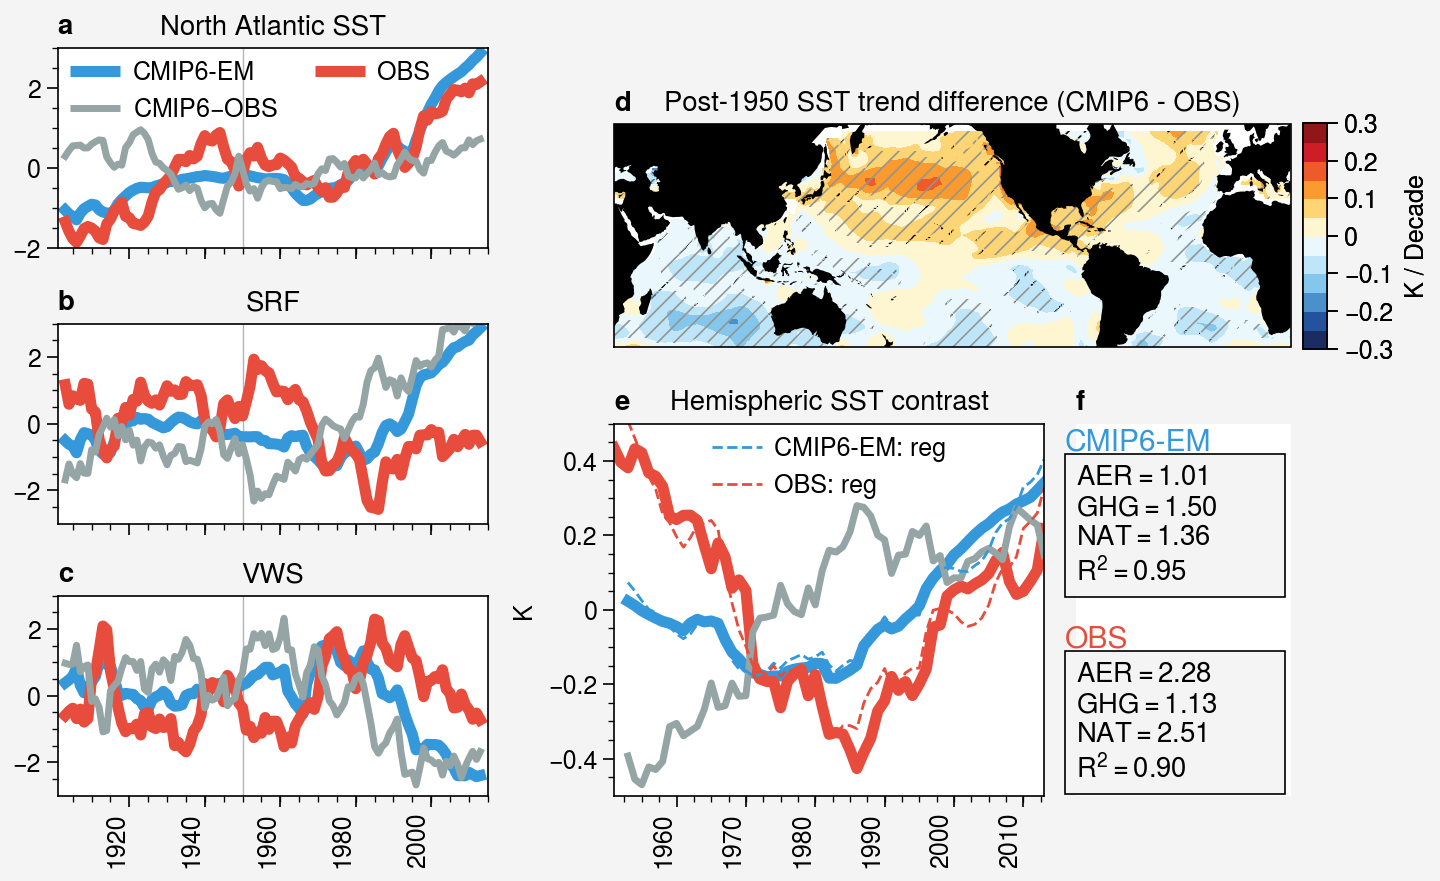

In [22]:
layout = [[1, 1, 4, 4, 4],
          [1, 1, 4, 4, 4],
          [2, 2, 4, 4, 4],
          [2, 2, 5, 5, 6],
          [3, 3, 5, 5, 6],
          [3, 3, 5, 5, 6]]

fig, axs = pplt.subplots(layout, sharey=False, sharex=False, proj={4:'merc'}, proj_kw={'lon_0': 210},
                          refnum=2, refwidth=2, refheight=1, journal='nat2', hratios=[1, 1, 1, 1, 1, 1])#wratios= [1, 1, 1, 1, 1, 1], hratios=[1, 1],
axs.format(land=True, landcolor='k')


tmp = ds.amv.mean('mb').rolling(time=5, center=True).mean().stat.normalize()
tmp.rename('').plot(ax=axs[0], label='CMIP6-EM', lw=4)

tmp1 = obs.amv.rolling(time=5, center=True).mean().stat.normalize()
tmp1.rename('').plot(ax=axs[0], label='OBS', lw=4)

dd = tmp - tmp1
dd.rename('').plot(ax=axs[0], label='CMIP6$-$OBS', lw=2.5)


tmp = ds.spr.mean('mb').rolling(time=5, center=True).mean().stat.normalize()
tmp.rename('').plot(ax=axs[1], label='CMIP6-EM', lw=4)

tmp1 = obs.spr.rolling(time=5, center=True).mean().stat.normalize()
tmp1.rename('').plot(ax=axs[1], label='OBS', lw=4)

ddspr = tmp - tmp1
ddspr.rename('').plot(ax=axs[1], label='CMIP6-OBS', lw=2.5)


tmp = ds.vws.mean('mb').rolling(time=5, center=True).mean().stat.normalize()
tmp.rename('').plot(ax=axs[2], label='CMIP6-EM', lw=4)

tmp1 = obs.vws.rolling(time=5, center=True).mean().stat.normalize()
tmp1.rename('').plot(ax=axs[2], label='OBS', lw=4)

ddvws = tmp - tmp1
ddvws.rename('').plot(ax=axs[2], label='CMIP6$-$OBS', lw=2.5)



lev = np.arange(-0.3, 0.31, 0.05)

slp_cv = rotate_lon2(slp)
pval_cv = rotate_lon2(pval)

m = axs[3].contourf(slp_cv.interpolate_na('lon2'), 
            # add_colorbar=False, 
            levels=lev, 
            cmap='ColdHot', 
            globe=True)

cs = axs[3].contourf(pval_cv.interpolate_na('lon2').where(pval_cv.interpolate_na('lon2')<=0.011), 
            [0,0.01,1],
                zorder=1, 
                hatches=['////', None],
                colors='none', )

for i, collection in enumerate(cs.collections):
    if i==0:
        collection.set_edgecolor('gray')
        # collection.set_facecolor('gray')
for collection in cs.collections:
    collection.set_linewidth(0.)

axs[3].colorbar(m, loc='r', length=0.6, width=0.12, label='K / Decade') 
axs[3].format(latlim=[-40, 60], title='Post-1950 SST trend difference (CMIP6 - OBS)') 

axs[4].format(ylim=[-0.5, 0.5], title='Hemispheric SST contrast')


ts_em.plot(ax=axs[4], lw=4)
ts_ob.plot(ax=axs[4], lw=4)
indx2.plot(ax=axs[4], lw=2.5)


df.model.plot(ax=axs[4], lw=1, c='C0', ls='dashed', label='CMIP6-EM: reg')
df.OBS.plot(ax=axs[4], lw=1, c='C1', ls='dashed', label='OBS: reg')

props = dict(facecolor='#F4F4F4')
textstr = '\n'.join((
    r'$AER=%.2f$         ' % (1.01, ),
    r'$GHG=%.2f$' % (1.50, ),
    r'$NAT=%.2f$' % (1.36, ), 
    r'$R^{2}=%.2f$' % (0.95, ), 
    ))
axs[5].text(0, 0.89, textstr, transform=axs[5].transAxes, fontsize='med-large', 
        verticalalignment='top', bbox=props)

axs[5].text(-0.05, 0.93, 'CMIP6-EM', transform=axs[5].transAxes, fontsize='large', c='C0',
        )

textstr = '\n'.join((
    r'$AER=%.2f$         ' % (2.28, ),
    r'$GHG=%.2f$' % (1.13, ),
    r'$NAT=%.2f$' % (2.51, ), 
    r'$R^{2}=%.2f$' % (0.90, ), 
    ))
axs[5].text(0, 0.36, textstr, transform=axs[5].transAxes, fontsize='med-large', 
        verticalalignment='top', bbox=props)

axs[5].text(-0.05, 0.4, 'OBS', transform=axs[5].transAxes, fontsize='large', c='C1',
        )

axs.format(abc=True)

axs[0].format(title='North Atlantic SST', ylim=[-2, 3])
axs[1].format(title='SRF', ylim=[-3, 3])
axs[2].format(title='VWS', ylim=[-3, 3])

axs[0].vlines(tmp.time.sel(time='1949'), -2, 3, c='gray5', lw=0.5)
axs[1].vlines(tmp.time.sel(time='1949'), -3, 3, c='gray5', lw=0.5)
axs[2].vlines(tmp.time.sel(time='1949'), -3, 3, c='gray5', lw=0.5)

axs[0:3].format(xlabel='')
axs[0:2].format(xticklabels=[])
axs[4].format(xlabel='', title='Hemispheric SST contrast', ylabel='K')

axs[5].format(yloc='none', xloc='none')
axs[4].legend(ncols=1, frame=False)
axs[0].legend(ncols=2, frame=False)
plt.savefig('1pfigs/r1.fig.new.1.20th.r1.pdf')
# plt.savefig('1pfigs/r1.fig.new.1.20th.r1.pdf')